# Assignment 6 - Part II

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
import random
from IPython.display import clear_output

# Enable inline plotting
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

--- Build a Simple MNIST Classifier ---

In [2]:
''' Build a simple MNIST classification CNN
    The network takes ~3 minutes to train on a normal laptop and reaches roughly 97% of accuracy
    Model structure: Conv, Conv, Max pooling, Dropout, Dense, Dense
'''
def build_mnist_model():
    
    activation = 'relu'
    # input image dimensions
    img_rows, img_cols, img_colors = 28, 28, 1
    
    model = keras.Sequential()
    model.add(layers.Conv2D(8, kernel_size=(3, 3), input_shape=(img_rows, img_cols, img_colors), activation=activation))
    model.add(layers.Conv2D(8, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation=activation))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes))
    model.add(layers.Activation('softmax', name='y_pred'))
              
    return model

In [3]:
''' Normalize input to the range of [0..1]
    Apart from assisting in the convergance of the training process, this 
    will also make our lives easier during the adversarial attack process
'''
def normalize(x_train,x_test):
    x_train -= x_train.min()
    x_train /= x_train.max()
    x_test -= x_test.min()
    x_test /= x_test.max()
    
    return x_train, x_test

In [4]:
# Load and prepare the datasets for training
num_classes = 10

img_rows, img_cols, img_colors = 28, 28, 1
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
train_images, test_images = normalize(train_images, test_images)
    
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

In [5]:
# Train the model
batch_size = 128
maxepoches = 12
learning_rate = 0.1
lr_decay = 1e-6
lr_drop = 20

def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

model = build_mnist_model()

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(),
              metrics=[keras.metrics.CategoricalAccuracy()])

history = model.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=maxepoches,
                    verbose=1,
                    validation_data=(test_images, test_labels),
                    callbacks=[reduce_lr])

Epoch 1/12
469/469 [==============================] - 18s 37ms/step - loss: 1.0074 - categorical_accuracy: 0.6775 - val_loss: 0.3184 - val_categorical_accuracy: 0.9087
Epoch 2/12
469/469 [==============================] - 18s 39ms/step - loss: 0.4671 - categorical_accuracy: 0.8537 - val_loss: 0.2467 - val_categorical_accuracy: 0.9286
Epoch 3/12
469/469 [==============================] - 19s 41ms/step - loss: 0.3942 - categorical_accuracy: 0.8792 - val_loss: 0.2086 - val_categorical_accuracy: 0.9398
Epoch 4/12
469/469 [==============================] - 18s 39ms/step - loss: 0.3449 - categorical_accuracy: 0.8948 - val_loss: 0.1825 - val_categorical_accuracy: 0.9457
Epoch 5/12
469/469 [==============================] - 18s 39ms/step - loss: 0.3024 - categorical_accuracy: 0.9081 - val_loss: 0.1615 - val_categorical_accuracy: 0.9513
Epoch 6/12
469/469 [==============================] - 19s 41ms/step - loss: 0.2720 - categorical_accuracy: 0.9178 - val_loss: 0.1416 - val_categorical_accuracy:

--- Understanding Vectors in Input Space ---

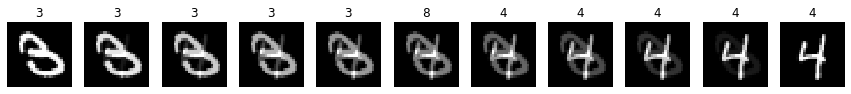

In [6]:
img_rows, img_cols = 28 , 28

x_start = test_images[18]
x_end = test_images[19]

max_steps = 11
steps = np.empty((max_steps, img_rows, img_cols, 1))
fig, ax = plt.subplots(nrows=1, ncols=max_steps, figsize=(15,3))
delta = (x_end - x_start)/(max_steps - 1)

for index in range(max_steps):
    steps[index] = x_start + index * delta   
    pred = np.argmax(model.predict(np.expand_dims(steps[index], 0)))
    ax[index].imshow(steps[index].reshape((img_rows, img_cols)), cmap='gray')
    ax[index].set_title(str(pred))
    ax[index].axis('off')

plt.show()

--- HopSkipJump Attack Implementation ---

In [7]:
@tf.function
def BoundaryBinSearch(classifier, source_x, dest_x, verbose=False):
    
    # Some preperation
    min_x = source_x
    max_x = dest_x
    # In case input included only a single image we need an extra dimension to
    # be able to use the neural network for prediction later on
    if (len(min_x.shape) == 3):
        min_x = tf.expand_dims(min_x, axis=0)
    if (len(max_x.shape) == 3):
        max_x = tf.expand_dims(max_x, axis=0)
    
    max_iteration = 100 
    epsilon = 1e-7
       
    min_y = classifier(min_x)

    # Compute the original distance between source and destination
    dist = np.inf
    mid_x = (min_x + max_x)/2
    
    iteration = 0
    while tf.greater(dist, epsilon) and iteration < max_iteration:
        if verbose and iteration % 5 == 0:
            tf.print('Bin Search Iteration: ', iteration, 'Mean dist: {0:.2f}', dist)
        
        iteration += 1
        
        # Calculate the mid point and the class label at that point
        min_y = classifier(min_x)
        max_y = classifier(max_x)
        mid_x = (min_x + max_x)/2
        mid_y = classifier(mid_x)
        
        sign = tf.dtypes.cast(tf.equal(tf.argmax(mid_y, axis=1), tf.argmax(max_y, axis=1)), tf.float32)
        
        # Reshape the sign vector so that we can later multiply the matrix by it and preserve the original 
        # dimensions of the input image
        sign = tf.expand_dims(tf.expand_dims(tf.expand_dims(sign, -1), -1), -1)
        
        # When sign equals to 1 we want to move the max to the mid (the mid is in the target class)
        # When sign equals to 0 we want to leave the max unchanged (the mid is in the source class)
        max_x = sign * mid_x + (1 - sign) * max_x
        
        # When sign equals to 1 we want to leave the min unchanged (the mid is in the target class)
        # When sign equals to 0 we want to move the min to the mid (the mid is in the source class)
        min_x = sign * min_x + (1 - sign) * mid_x
        
        dist = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(max_x - min_x), axis=(1,2,3))))
        
    return mid_x

In [108]:
# The target tensor will be populated with a one-hot representation of the target

# S is our optimization function. It is positive if and only if the predicted class is the target one
# Since target_tensor is a one hot matrix, multiplying it with the model's output will nullify all but the
# target probability estimates. Taking a 'max' over that tensor will result with a column tensor with the probability of the 
# target class.
# Similarly, 1 - target_tensor will nullify only the target class probability estimate. Taking a max in this case will
# create a column tensor with the maximal estimate of all non-target classes.
# Together those elements provide the delta between the target class and the second highest probability.

def BoundarySlide(classifier, mid_x, target, iteration):
    perpendicular_step = 0.1 / (2 ** iteration)
    target_vec = np.ones(mid_x.shape[0]) * target
    target_vec = keras.utils.to_categorical(target_vec, num_classes)
    target_tensor = tf.Variable(target_vec)
    
    # Take a small step in the direction of the gradient
    mid_x_tensor = tf.Variable(mid_x)
    with tf.GradientTape() as g:
        g.watch(mid_x_tensor)
        mid_y_tensor = classifier(mid_x_tensor)
        S = tf.math.reduce_max(mid_y_tensor * target_tensor, axis=1)
        S -= tf.math.reduce_max((1 - target_tensor) * mid_y_tensor, axis=1)
    
    grads = g.gradient(S, mid_x_tensor)
    grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=(1,2,3), keepdims=True))
    
    return mid_x + perpendicular_step * (grads / grad_norm)

In [109]:
def WhiteboxHopSkipJump(classifier, source_x, dest_x, max_iterations = 200, target=0, collect_boundaries=False):
    # Iterate -
    # 1. Find the mid points between source and dest using binary search
    # 2. Slide along the gradient
    epsilon = 1e-5
    last_dist = np.inf
    next_x = np.copy(dest_x)
    boundaries = []
    
    for iteration in range(max_iterations):
        clear_output(wait=True)
        print('HopSkip Iteration: ', iteration)

        # TODO: Find current boundary point
        next_x = BoundaryBinSearch(classifier, source_x, dest_x, verbose=False) 
        
        if collect_boundaries:
            boundaries.append(next_x)
        # TODO: Slide along the gradient    
        next_x = BoundarySlide(classifier, next_x, dest_x, iteration+1)

        # TODO: Clip or project the values in 'next_x' to maintain validity
        next_x = tf.clip_by_value(next_x, 0, 255) 
        
        # TODO: Calculate the distance to the boundary point
#         dist = np.linalg.norm(next_x-source_x)
        dist = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(next_x - source_x), axis=(1,2,3))))
        
        # Stop when the distance to the boundary can not be further reduced
        print(f"dist is {dist}, last_dist is {last_dist}")
        if abs(dist - last_dist) < epsilon:
            break
        else:
            last_dist = dist
    
    return next_x, boundaries

In [10]:
def PrepareAttackImages(test_images, test_labels, source_index=None, samples=100):
    # Randmly choose a source image, then choose 100 destination images of a random target class
    if source_index is None:
        source_index = random.randint(0,test_images.shape[0])   
    source_class = np.argmax(test_labels[source_index])
    target_class = (source_class + random.randint(1, num_classes-1)) % num_classes
    
    # Filter out all test images of the source class into test_images_a
    mask = np.argmax(test_labels, axis=1) == source_class
    test_images_a = test_images[mask]
    
    # Filter out all test images of the target class into test_images_b
    mask = np.argmax(test_labels, axis=1) == target_class
    test_images_b = test_images[mask]
    
    # We need image pairs for running the HopSkipJump attack. The source image is replicated for all pairs while
    # the destination image is chosen randomly from the test set
    source_x = np.repeat(np.expand_dims(test_images[source_index], axis=0),samples, axis=0)
    dest_x = test_images_b[np.random.choice(range(test_images_b.shape[0]), size=samples, replace=False)]
    
    return source_x, dest_x, source_class, target_class

In [35]:
''' A simple utility funcion for evaluating the success of an attack
'''
def TestAttack(model, adv_images, orig_images, true_label, target_label = None, boundaries = None):
    preds = model.predict(adv_images)
    score = np.sum(np.argmax(preds, axis = 1) != true_label)
    score /= adv_images.shape[0]
    print('Successfully moved out of source class: {:.2f}'.format(score))
    
    if target_label is not None:
        score = np.sum(np.argmax(preds, axis = 1) == target_label)
        score /= adv_images.shape[0]
        print('Successfully perturbed to target class: {:.2f}'.format(score))
    
    dist = np.mean(np.sqrt(np.mean(np.square(adv_images - orig_images), axis=(1,2,3))))
    print('Mean perturbation distance: {:.2f}'.format(dist))
    
    # When the intermediate boundary images are provided we plot them all
    # otherwise, choose the end result of one attack pair and plot it
    if boundaries is None:
        index = 10
        img = adv_images[index].reshape(28, 28)
        plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    else:
        cols = 8
        rows = math.ceil(len(boundaries) / cols)
        fig, ax = plt.subplots(nrows=rows, ncols = cols, figsize=(8, 1.25*rows))
        for index in range(rows*cols):
            if index < len(boundaries):
                img = boundaries[index][0].reshape(28, 28)
                if rows > 1:
                    ax[index // cols, index % cols].imshow(img, vmin=0, vmax=1, cmap='gray')
                    ax[index // cols, index % cols].set_title(str(index))
                    ax[index // cols, index % cols].axis('off')

                else:
                    ax[index % cols].imshow(img, vmin=0, vmax=1, cmap='gray')
                    ax[index % cols].set_title(str(index))
                    ax[index % cols].axis('off')

    plt.show()

HopSkip Iteration:  10
dist is 1.9884494543075562, last_dist is 1.9884588718414307
Source index: 1751 Source class: 4 Target class: 2
Mean boundary distance: 9.91
Successfully moved out of source class: 1.00
Successfully perturbed to target class: 0.96
Mean perturbation distance: 0.07


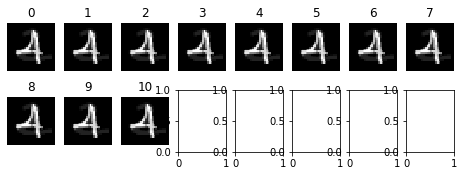

In [110]:
samples = 100
dist = np.zeros((samples))
adv_dist = np.zeros((samples))
    
# Choose a random starting point and create image pairs for the attack
source_index = random.randint(0,test_images.shape[0])
source_x, dest_x, source, target = PrepareAttackImages(test_images, test_labels, source_index=source_index, samples=samples)

# Calc the distance between the source and dest images
for index in range(samples):
    dist[index] = np.linalg.norm(source_x[index] - dest_x[index])

# Craft adversarial attacks against the selected source image with HopSkipJump
adv_x, boundaries = WhiteboxHopSkipJump(model, source_x, dest_x, target=target, max_iterations = 100, collect_boundaries=True)
print('Source index:', source_index, 'Source class:', source, 'Target class:', target)
print('Mean boundary distance:', round(np.mean(dist),2))

# Convert boundary images into numpy arrays (as opposed to tensors)
for index in range(len(boundaries)):
    boundaries[index] = boundaries[index].numpy()
TestAttack(model, adv_x.numpy(), source_x, source, target_label=target, boundaries=boundaries)
    

--- STOP HERE ---